# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

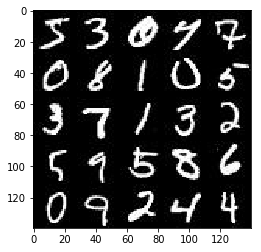

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

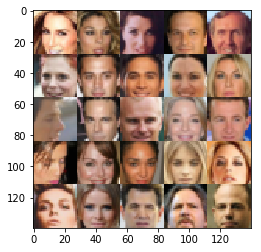

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, name='lr')

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        #print(conv1.get_shape().as_list())
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, 2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        #print(conv2.get_shape().as_list())
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, 2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)
        #print(conv3.get_shape().as_list())
        
        conv4 = tf.layers.conv2d(conv3, 512, 5, 1, padding='same')
        conv4 = tf.layers.batch_normalization(conv4, training=True)
        conv4 = tf.maximum(alpha * conv4, conv4)
        #print(conv4.get_shape().as_list())
        
        dimensions = conv4.get_shape().as_list()
        flatten = tf.reshape(conv4, (-1, dimensions[1]*dimensions[2]*dimensions[3]))
        logits = tf.layers.dense(flatten, 1)
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        dense = tf.layers.dense(z, 2*2*1024)
        dense = tf.reshape(dense, (-1, 2, 2, 1024))
        dense_norm = tf.layers.batch_normalization(dense, training=is_train)
        dense_relu = tf.maximum(alpha * dense_norm, dense_norm)
        #dense_relu = tf.nn.relu(dense_norm)
        
        #print(dense_relu.get_shape().as_list())
        conv1 = tf.layers.conv2d_transpose(dense_relu, 512, 3, 2, padding='SAME')
        #print(conv1.get_shape().as_list())
        conv1_norm = tf.layers.batch_normalization(conv1, training=is_train)
        conv1_relu = tf.maximum(alpha * conv1_norm, conv1_norm)
        #conv1_relu = tf.nn.relu(conv1_norm)
        
        #print(conv1_relu.get_shape().as_list())
        conv2 = tf.layers.conv2d_transpose(conv1_relu, 256, 4, 1, padding='VALID')
        #print(conv2.get_shape().as_list())
        conv2_norm = tf.layers.batch_normalization(conv2, training=is_train)
        conv2_relu = tf.maximum(alpha * conv2_norm, conv2_norm)
        #conv1_relu = tf.nn.relu(conv1_norm)
        
        #print(conv2_relu.get_shape().as_list())
        conv3 = tf.layers.conv2d_transpose(conv2_relu, 128, 5, 2, padding='SAME')
        #print(conv3.get_shape().as_list())
        conv3_norm = tf.layers.batch_normalization(conv3, training=is_train)
        conv3_relu = tf.maximum(alpha * conv3_norm, conv3_norm)
        #conv2_relu = tf.nn.relu(conv2_norm)
        
        
        #print(conv3_relu.get_shape().as_list())
        conv4 = tf.layers.conv2d_transpose(conv3_relu, out_channel_dim, 5, 2, padding='SAME')
        #print(conv4.get_shape().as_list())
        output = tf.nn.tanh(conv4)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_input, z_input, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                num_gen = 2
                batch_z = np.random.uniform(-1, 1, size=(num_gen, batch_size, z_dim))
                
                #normalize images from (-0.5, 0.5) to (-1, 1)
                batch_images = batch_images * 2
                
                sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: batch_z[0]})
                for i in range(num_gen):
                    sess.run(g_train_opt, feed_dict={z_input: batch_z[i], real_input: batch_images})
                #sess.run(g_train_opt, feed_dict={z_input: batch_z2, real_input: batch_images})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z[0], real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z[0]})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps%100 == 0:
                    show_generator_output(sess, 9, z_input, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0592... Generator Loss: 5.5998
Epoch 1/2... Discriminator Loss: 3.0672... Generator Loss: 0.0555
Epoch 1/2... Discriminator Loss: 3.3863... Generator Loss: 0.0400
Epoch 1/2... Discriminator Loss: 2.0377... Generator Loss: 0.1800
Epoch 1/2... Discriminator Loss: 2.0126... Generator Loss: 0.4817
Epoch 1/2... Discriminator Loss: 2.0760... Generator Loss: 0.1746
Epoch 1/2... Discriminator Loss: 2.2332... Generator Loss: 0.1505
Epoch 1/2... Discriminator Loss: 1.3543... Generator Loss: 0.4369
Epoch 1/2... Discriminator Loss: 1.1005... Generator Loss: 0.6031
Epoch 1/2... Discriminator Loss: 1.2560... Generator Loss: 0.3887


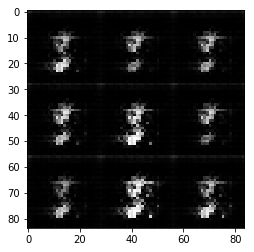

Epoch 1/2... Discriminator Loss: 2.5650... Generator Loss: 0.4662
Epoch 1/2... Discriminator Loss: 0.5805... Generator Loss: 1.5680
Epoch 1/2... Discriminator Loss: 0.8277... Generator Loss: 1.6851
Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 0.5218
Epoch 1/2... Discriminator Loss: 0.5576... Generator Loss: 1.6477
Epoch 1/2... Discriminator Loss: 0.6230... Generator Loss: 1.4830
Epoch 1/2... Discriminator Loss: 1.9253... Generator Loss: 0.6665
Epoch 1/2... Discriminator Loss: 2.5790... Generator Loss: 0.6439
Epoch 1/2... Discriminator Loss: 1.0328... Generator Loss: 1.1837
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 1.0118


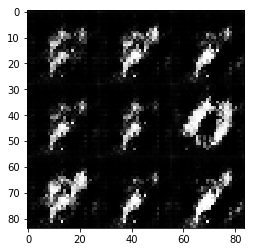

Epoch 1/2... Discriminator Loss: 1.5570... Generator Loss: 1.7024
Epoch 1/2... Discriminator Loss: 1.1156... Generator Loss: 0.9091
Epoch 1/2... Discriminator Loss: 1.0131... Generator Loss: 1.1963
Epoch 1/2... Discriminator Loss: 0.8404... Generator Loss: 2.4092
Epoch 1/2... Discriminator Loss: 1.7358... Generator Loss: 2.1687
Epoch 1/2... Discriminator Loss: 1.1800... Generator Loss: 0.8571
Epoch 1/2... Discriminator Loss: 1.8975... Generator Loss: 1.2587
Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 0.5187
Epoch 1/2... Discriminator Loss: 1.7974... Generator Loss: 0.3432
Epoch 1/2... Discriminator Loss: 1.5308... Generator Loss: 0.4286


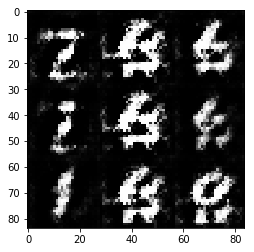

Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 1.1719
Epoch 1/2... Discriminator Loss: 1.9806... Generator Loss: 0.4361
Epoch 1/2... Discriminator Loss: 1.7840... Generator Loss: 0.7228
Epoch 1/2... Discriminator Loss: 1.1756... Generator Loss: 1.1453
Epoch 1/2... Discriminator Loss: 1.2567... Generator Loss: 1.0779
Epoch 1/2... Discriminator Loss: 1.9977... Generator Loss: 0.3758
Epoch 1/2... Discriminator Loss: 1.1885... Generator Loss: 0.9465
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 1.4002
Epoch 1/2... Discriminator Loss: 1.4470... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 1.6314... Generator Loss: 0.3600


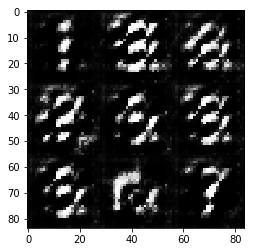

Epoch 1/2... Discriminator Loss: 1.4927... Generator Loss: 0.4601
Epoch 1/2... Discriminator Loss: 1.2156... Generator Loss: 0.5693
Epoch 1/2... Discriminator Loss: 1.5671... Generator Loss: 0.3778
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 1.6028
Epoch 1/2... Discriminator Loss: 1.6214... Generator Loss: 0.4981
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 0.8972
Epoch 1/2... Discriminator Loss: 1.5140... Generator Loss: 0.3751
Epoch 1/2... Discriminator Loss: 1.4221... Generator Loss: 0.4689
Epoch 1/2... Discriminator Loss: 1.2338... Generator Loss: 0.8013
Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 0.8265


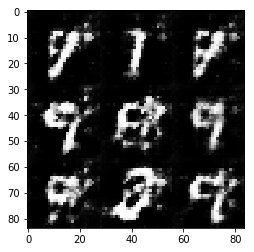

Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 0.9223
Epoch 1/2... Discriminator Loss: 1.4689... Generator Loss: 0.3986
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.4850
Epoch 1/2... Discriminator Loss: 2.0600... Generator Loss: 0.1841
Epoch 1/2... Discriminator Loss: 1.3244... Generator Loss: 0.6004
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.8650
Epoch 1/2... Discriminator Loss: 1.3102... Generator Loss: 0.7683
Epoch 1/2... Discriminator Loss: 1.1562... Generator Loss: 0.9625
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.8045
Epoch 1/2... Discriminator Loss: 1.0693... Generator Loss: 1.8430


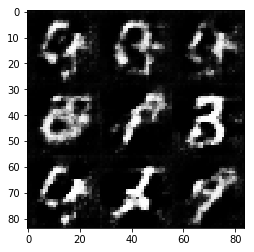

Epoch 1/2... Discriminator Loss: 1.6746... Generator Loss: 1.0392
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.7340
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.6573
Epoch 1/2... Discriminator Loss: 1.1374... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 1.0639
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 0.6267
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.9929
Epoch 1/2... Discriminator Loss: 1.7138... Generator Loss: 0.3129
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 1.1323
Epoch 1/2... Discriminator Loss: 1.1961... Generator Loss: 1.1611


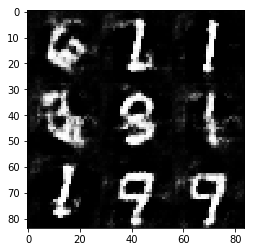

Epoch 1/2... Discriminator Loss: 1.3287... Generator Loss: 0.6745
Epoch 1/2... Discriminator Loss: 1.2508... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 0.6449
Epoch 1/2... Discriminator Loss: 1.2445... Generator Loss: 0.5308
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.5884
Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 1.5108
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 1.2950
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.5567
Epoch 1/2... Discriminator Loss: 1.1825... Generator Loss: 1.0251
Epoch 1/2... Discriminator Loss: 1.4733... Generator Loss: 0.3962


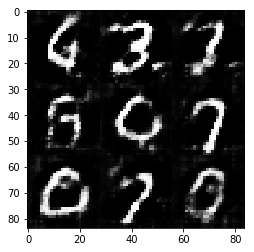

Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.8509
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.8920
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.4121
Epoch 1/2... Discriminator Loss: 1.0298... Generator Loss: 0.8089
Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 1.6432... Generator Loss: 0.3546
Epoch 1/2... Discriminator Loss: 1.5122... Generator Loss: 1.0582
Epoch 1/2... Discriminator Loss: 1.2156... Generator Loss: 1.2511
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 1.4676... Generator Loss: 1.6914


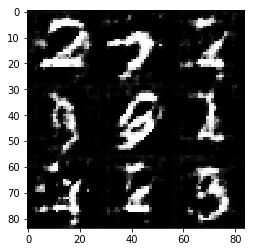

Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 1.1441
Epoch 1/2... Discriminator Loss: 1.4376... Generator Loss: 0.4276
Epoch 1/2... Discriminator Loss: 1.4829... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 1.5110... Generator Loss: 0.3492
Epoch 2/2... Discriminator Loss: 1.3016... Generator Loss: 0.9891
Epoch 2/2... Discriminator Loss: 1.2531... Generator Loss: 0.6200
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.5516
Epoch 2/2... Discriminator Loss: 1.3085... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.5729... Generator Loss: 0.3808
Epoch 2/2... Discriminator Loss: 1.3998... Generator Loss: 0.4427


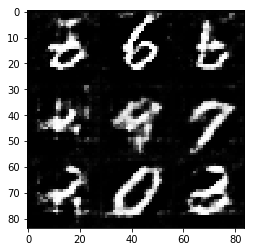

Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 0.4975
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.8970
Epoch 2/2... Discriminator Loss: 1.1937... Generator Loss: 1.2075
Epoch 2/2... Discriminator Loss: 1.4690... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 0.8128
Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 0.7509
Epoch 2/2... Discriminator Loss: 1.3301... Generator Loss: 0.6230
Epoch 2/2... Discriminator Loss: 1.3914... Generator Loss: 0.5259
Epoch 2/2... Discriminator Loss: 1.4503... Generator Loss: 0.4967
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.5321


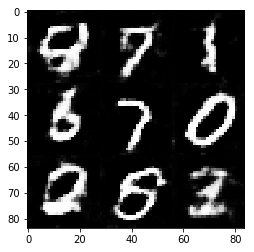

Epoch 2/2... Discriminator Loss: 1.1031... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 1.1335... Generator Loss: 0.8064
Epoch 2/2... Discriminator Loss: 1.4444... Generator Loss: 0.4046
Epoch 2/2... Discriminator Loss: 0.9564... Generator Loss: 1.2266
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.5849
Epoch 2/2... Discriminator Loss: 1.1578... Generator Loss: 0.7575
Epoch 2/2... Discriminator Loss: 1.4398... Generator Loss: 0.4138
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 1.1134
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.8846
Epoch 2/2... Discriminator Loss: 1.3248... Generator Loss: 0.5542


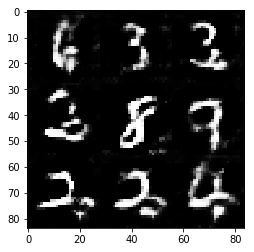

Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 1.1065
Epoch 2/2... Discriminator Loss: 1.2350... Generator Loss: 1.0322
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 1.1733
Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 0.5907
Epoch 2/2... Discriminator Loss: 1.3109... Generator Loss: 0.5416
Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 0.4494
Epoch 2/2... Discriminator Loss: 1.5520... Generator Loss: 1.1147
Epoch 2/2... Discriminator Loss: 1.4225... Generator Loss: 0.4502
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 0.8500
Epoch 2/2... Discriminator Loss: 1.3148... Generator Loss: 1.3862


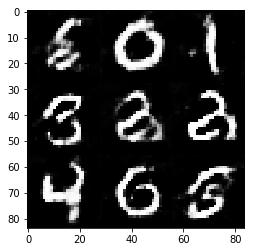

Epoch 2/2... Discriminator Loss: 1.4038... Generator Loss: 0.4217
Epoch 2/2... Discriminator Loss: 1.5790... Generator Loss: 0.9286
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.5908
Epoch 2/2... Discriminator Loss: 1.2859... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 1.8560... Generator Loss: 1.7734
Epoch 2/2... Discriminator Loss: 1.3699... Generator Loss: 0.4825
Epoch 2/2... Discriminator Loss: 1.4409... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 1.1438... Generator Loss: 0.9567
Epoch 2/2... Discriminator Loss: 1.4747... Generator Loss: 0.4909
Epoch 2/2... Discriminator Loss: 1.2106... Generator Loss: 0.8394


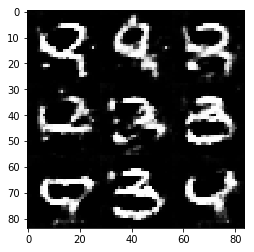

Epoch 2/2... Discriminator Loss: 1.3458... Generator Loss: 0.6250
Epoch 2/2... Discriminator Loss: 1.3014... Generator Loss: 0.5757
Epoch 2/2... Discriminator Loss: 1.7184... Generator Loss: 0.2878
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 1.3000... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 1.4792... Generator Loss: 0.3851
Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.5440
Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 0.5613
Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.4245


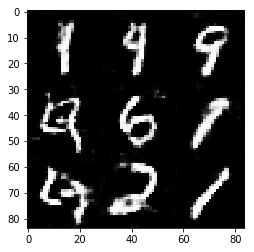

Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.6465
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 0.9790
Epoch 2/2... Discriminator Loss: 1.0067... Generator Loss: 0.8694
Epoch 2/2... Discriminator Loss: 1.0878... Generator Loss: 1.1072
Epoch 2/2... Discriminator Loss: 1.3796... Generator Loss: 0.4372
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.8266
Epoch 2/2... Discriminator Loss: 1.2847... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.4948
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.6932
Epoch 2/2... Discriminator Loss: 1.4606... Generator Loss: 0.4253


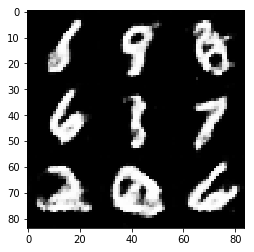

Epoch 2/2... Discriminator Loss: 1.6608... Generator Loss: 0.2828
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 1.3337
Epoch 2/2... Discriminator Loss: 1.1284... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 1.4189... Generator Loss: 0.4208
Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 1.3563
Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 0.7177
Epoch 2/2... Discriminator Loss: 1.2224... Generator Loss: 0.5670
Epoch 2/2... Discriminator Loss: 2.0169... Generator Loss: 0.1860
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 0.6033
Epoch 2/2... Discriminator Loss: 1.4294... Generator Loss: 0.4040


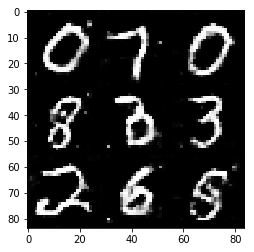

Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.7921
Epoch 2/2... Discriminator Loss: 1.3428... Generator Loss: 0.6608
Epoch 2/2... Discriminator Loss: 1.2540... Generator Loss: 0.8846
Epoch 2/2... Discriminator Loss: 1.4295... Generator Loss: 1.4703
Epoch 2/2... Discriminator Loss: 1.3293... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 0.6564
Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 1.4098... Generator Loss: 0.4045
Epoch 2/2... Discriminator Loss: 1.2600... Generator Loss: 0.4432
Epoch 2/2... Discriminator Loss: 1.3896... Generator Loss: 0.9165


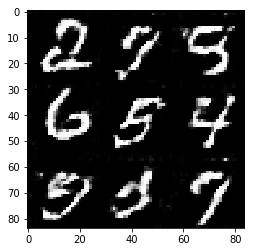

Epoch 2/2... Discriminator Loss: 1.1863... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.4629... Generator Loss: 0.3738
Epoch 2/2... Discriminator Loss: 1.7949... Generator Loss: 0.2229
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.6680
Epoch 2/2... Discriminator Loss: 1.4236... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 1.2591... Generator Loss: 0.9824
Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 0.4322


In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.9272... Generator Loss: 0.0080
Epoch 1/1... Discriminator Loss: 5.6988... Generator Loss: 13.5623
Epoch 1/1... Discriminator Loss: 1.5580... Generator Loss: 0.4105
Epoch 1/1... Discriminator Loss: 3.0012... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 2.1415... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 2.0794... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.7353... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.9415... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 1.5001
Epoch 1/1... Discriminator Loss: 1.8849... Generator Loss: 0.8568


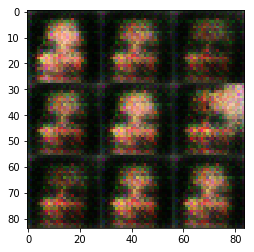

Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.6577... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.7479... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.8854... Generator Loss: 0.3940
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.9400... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.5669... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.5873... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.6097... Generator Loss: 0.6783


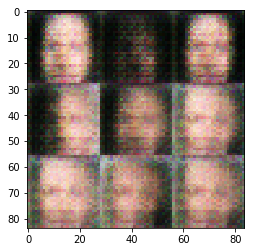

Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.6096... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6552


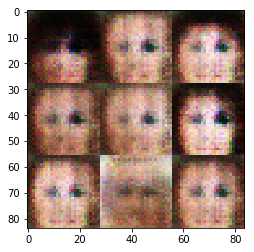

Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.6830... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7213


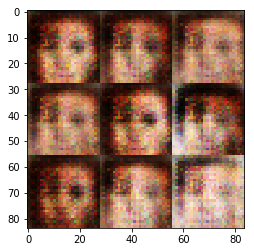

Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.5474... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.6034... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.6699


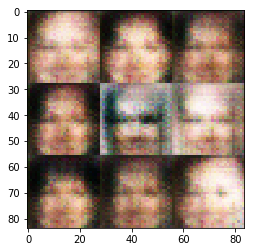

Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6101


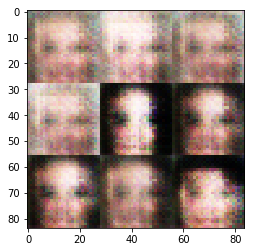

Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.5470... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6073


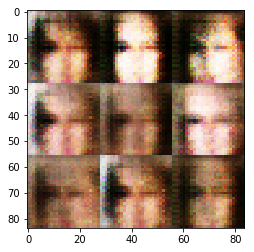

Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.5994


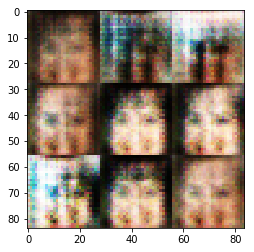

Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6207
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.5858... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.7161


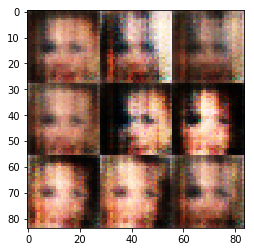

Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.6776


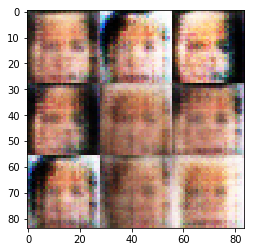

Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6164
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.8379


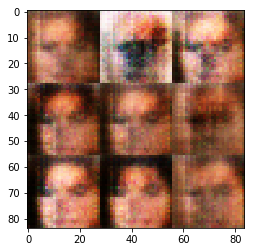

Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.6280... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.6729


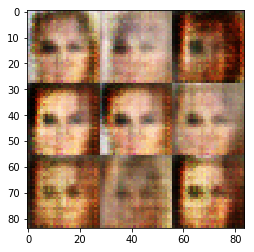

Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.5720
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6773


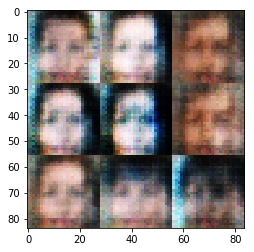

Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6668


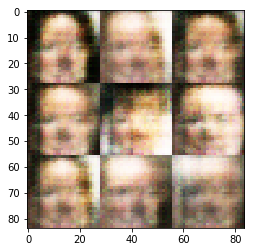

Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 1.0164
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6241


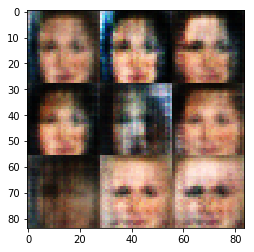

Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.8660


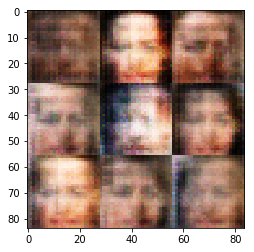

Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6301


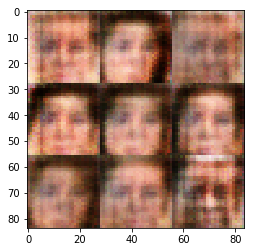

Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.8518


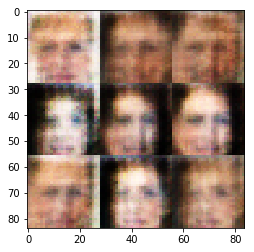

Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6863


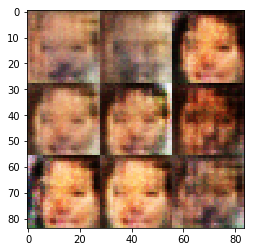

Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.5933


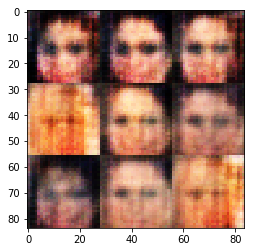

Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6744


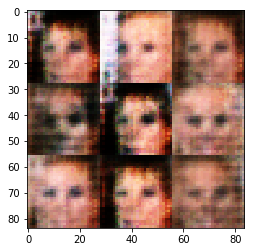

Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.5881


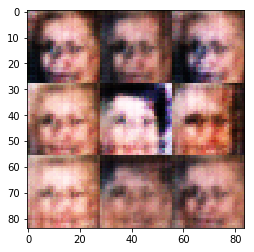

Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6366


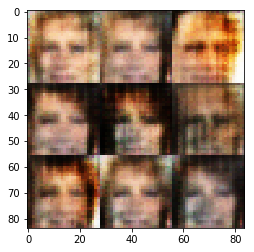

Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7164


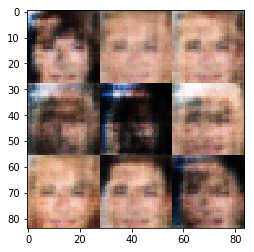

Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.4820
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.4564
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.5307
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7944


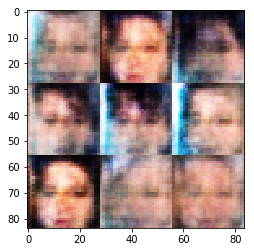

Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.4778
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.5134


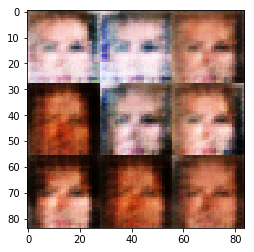

Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6904


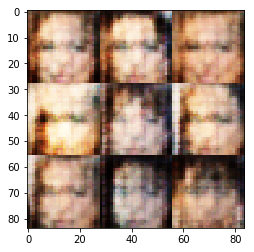

Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7592


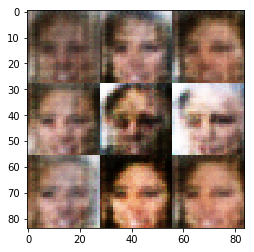

Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6666


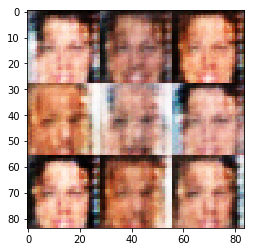

Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6411


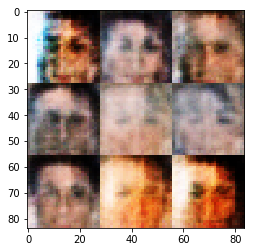

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7098


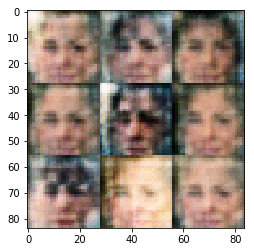

Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.6640


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.